In [1]:
import os
import random
import numpy as np
import pandas as pd  # Added import
import json
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import RMSprop
from PIL import Image
import matplotlib.pyplot as plt

In [12]:
# Set the main dataset directory and other parameters
dataset_dir = 'DATASET'
input_shape = (150, 150, 3)
num_classes = len(os.listdir(dataset_dir))
batch_size = 32
epochs = 50
test_size = 0.2

In [13]:
# Get the list of all image files
image_files = []
labels = []
for label in os.listdir(dataset_dir):
    label_dir = os.path.join(dataset_dir, label)
    if os.path.isdir(label_dir):
        for file_name in os.listdir(label_dir):
            image_files.append(os.path.join(label_dir, file_name))
            labels.append(label)
# # Get the list of all image files
# image_files = []
# labels = []
# for label in os.listdir(dataset_dir):
#     label_dir = os.path.join(dataset_dir, label)
#     if os.path.isdir(label_dir):
#         for file_name in os.listdir(label_dir):
#             image_path = os.path.join(label_dir, file_name)
#             image_files.append(image_path)
#             labels.append(label)

#             # Check image metadata for orientation information
#             with Image.open(image_path) as img:
#                 metadata = img._getexif()
#                 if metadata is not None and 0x0112 in metadata:
#                     orientation = metadata[0x0112]
#                     print(f"Orientation of {image_path}: {orientation}")
# Perform train-test split
train_files, validation_files, train_labels, validation_labels = train_test_split(
    image_files, labels, test_size=test_size, stratify=labels, random_state=42
)
# Preprocess images to correct rotation (portrait orientation)
# for file_path in train_files + validation_files:
#     img = Image.open(file_path)
#     width, height = img.size
#     if width > height:  # Landscape orientation
#         img = img.transpose(Image.ROTATE_90)
#         img.save(file_path)

Found 3541 validated image filenames belonging to 26 classes.
Found 886 validated image filenames belonging to 26 classes.


d:\TEKKOM UB\Bangkit 2023\Capstone\Indonesian-Sign-Language-ISL-\.venv\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


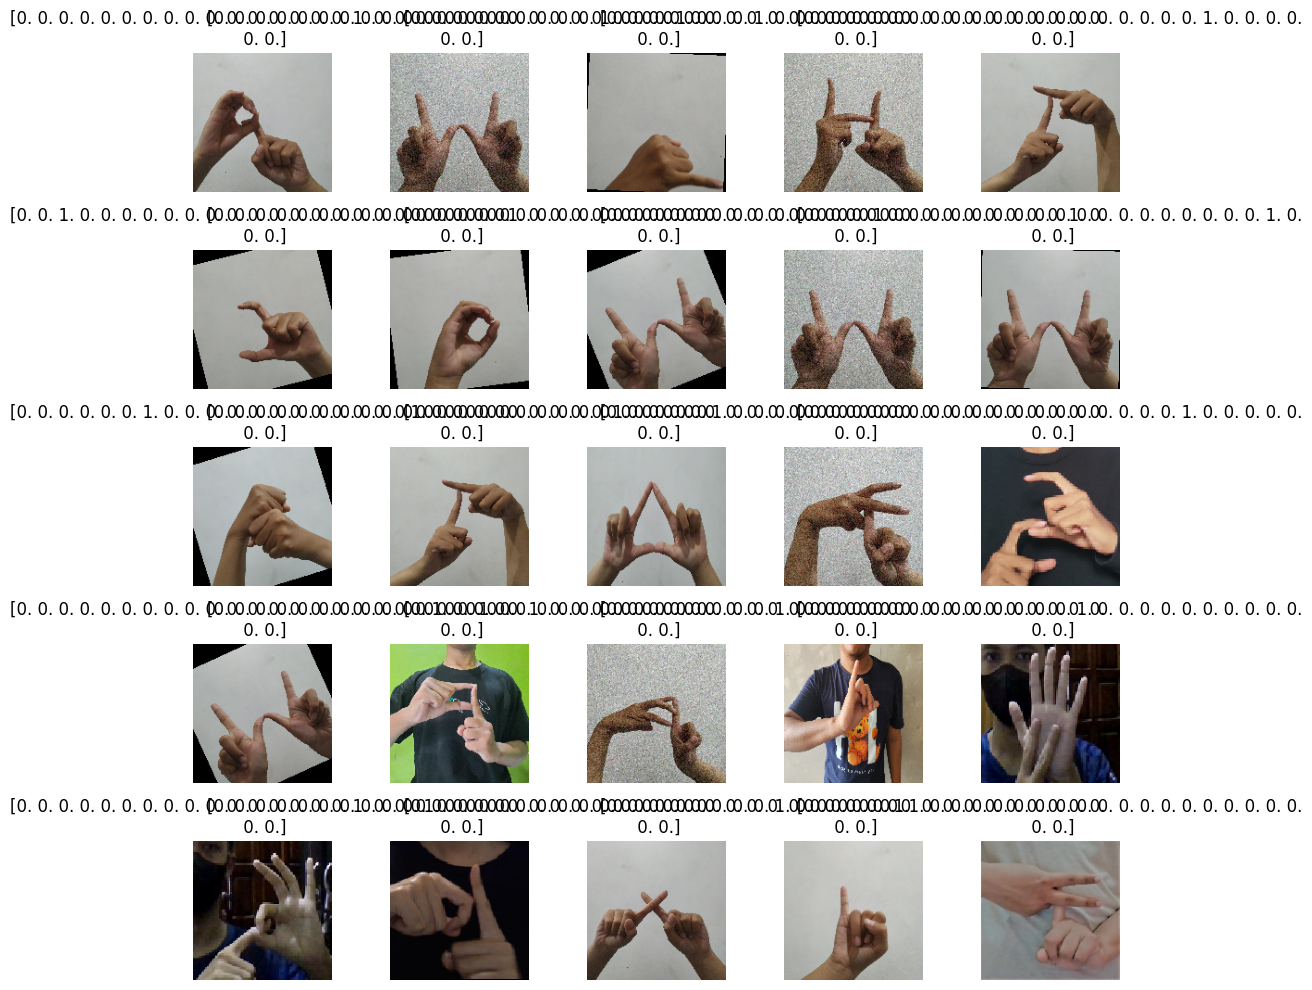

In [14]:
# Create image data generator with augmentation
datagen = ImageDataGenerator(
                                rescale=1/255,
                                # zoom_range=0.1,
                                # width_shift_range=0.2,
                                # height_shift_range=0.2,
                                # shear_range=0.2,
                                
)

# Generate training and validation data
train_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': train_files, 'label': train_labels}),
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = datagen.flow_from_dataframe(
    pd.DataFrame({'filename': validation_files, 'label': validation_labels}),
    x_col='filename',
    y_col='label',
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)
# Display sample data
sample_images, sample_labels = next(train_generator)

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(sample_images[i])
    plt.title(sample_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

In [17]:
# Define callback to stop training if accuracy exceeds 90%
class AccuracyThresholdCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95 :
            print("\nReached 90% validation accuracy. Stopping training.")
            self.model.stop_training = True

In [18]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[AccuracyThresholdCallback()]
)



Epoch 1/50
110/110 [==============================] - 157s 1s/step - loss: 3.6259 - accuracy: 0.0986 - val_loss: 3.3917 - val_accuracy: 0.3287
Epoch 2/50
110/110 [==============================] - 152s 1s/step - loss: 2.9948 - accuracy: 0.3334 - val_loss: 2.4549 - val_accuracy: 0.6042
Epoch 3/50
110/110 [==============================] - 151s 1s/step - loss: 2.1950 - accuracy: 0.5190 - val_loss: 1.7935 - val_accuracy: 0.6771
Epoch 4/50
110/110 [==============================] - 150s 1s/step - loss: 1.6629 - accuracy: 0.6583 - val_loss: 1.4641 - val_accuracy: 0.7164
Epoch 5/50
110/110 [==============================] - 150s 1s/step - loss: 1.3704 - accuracy: 0.7199 - val_loss: 1.2914 - val_accuracy: 0.7407
Epoch 6/50
110/110 [==============================] - 150s 1s/step - loss: 1.1550 - accuracy: 0.7657 - val_loss: 1.1528 - val_accuracy: 0.7650
Epoch 7/50
110/110 [==============================] - 149s 1s/step - loss: 1.0014 - accuracy: 0.7962 - val_loss: 1.0721 - val_accuracy: 0.7836

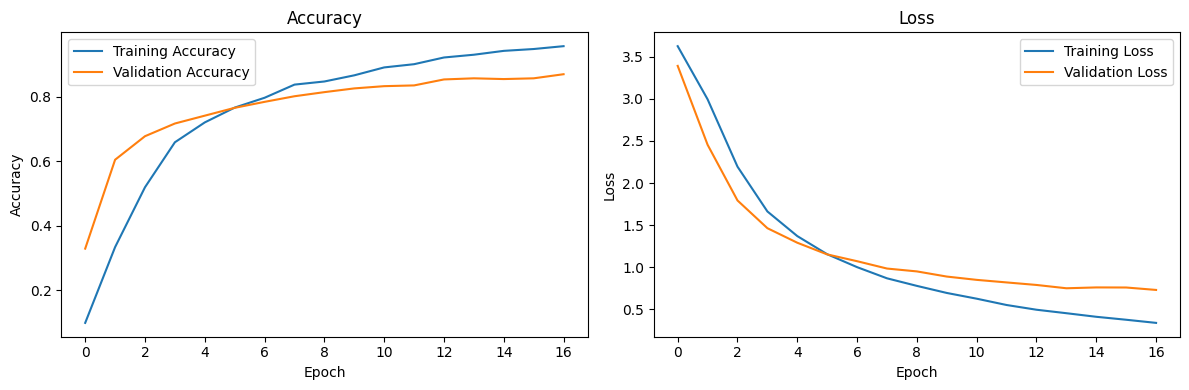

In [20]:
# Plot accuracy and loss curves
# Plot accuracy and loss curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [21]:
# Print out loss and accuracy
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss[epoch]:.4f} - Train Accuracy: {train_accuracy[epoch]:.4f}")
    print(f"Validation Loss: {val_loss[epoch]:.4f} - Validation Accuracy: {val_accuracy[epoch]:.4f}")
    print()

Epoch 1/50
Train Loss: 3.6259 - Train Accuracy: 0.0986
Validation Loss: 3.3917 - Validation Accuracy: 0.3287

Epoch 2/50
Train Loss: 2.9948 - Train Accuracy: 0.3334
Validation Loss: 2.4549 - Validation Accuracy: 0.6042

Epoch 3/50
Train Loss: 2.1950 - Train Accuracy: 0.5190
Validation Loss: 1.7935 - Validation Accuracy: 0.6771

Epoch 4/50
Train Loss: 1.6629 - Train Accuracy: 0.6583
Validation Loss: 1.4641 - Validation Accuracy: 0.7164

Epoch 5/50
Train Loss: 1.3704 - Train Accuracy: 0.7199
Validation Loss: 1.2914 - Validation Accuracy: 0.7407

Epoch 6/50
Train Loss: 1.1550 - Train Accuracy: 0.7657
Validation Loss: 1.1528 - Validation Accuracy: 0.7650

Epoch 7/50
Train Loss: 1.0014 - Train Accuracy: 0.7962
Validation Loss: 1.0721 - Validation Accuracy: 0.7836

Epoch 8/50
Train Loss: 0.8689 - Train Accuracy: 0.8370
Validation Loss: 0.9848 - Validation Accuracy: 0.8009

Epoch 9/50
Train Loss: 0.7789 - Train Accuracy: 0.8467
Validation Loss: 0.9509 - Validation Accuracy: 0.8137

Epoch 10/5

IndexError: list index out of range

In [ ]:
# Save the trained model
model.save('image_classifier_model_3.h5')

In [3]:
from tensorflow.keras.models import model_from_json
# Load the model from .h5 file
model = keras.models.load_model('image_classifier_model_3.h5')

# Convert model architecture to JSON
model_json = model.to_json()

# Save the JSON to a file
with open('image_classifier_model_3.json', 'w') as json_file:
    json_file.write(model_json)

# Save model weights to a separate file
model.save_weights('image_classifier_weights.h5')

print("Model converted to JSON and saved as image_classifier_model.json.")

Model converted to JSON and saved as image_classifier_model.json.
